# Binary Classifier Evaluation Metrics

In [66]:
import sklearn.metrics
import numpy as np
import jax
import jax.numpy as jnp
from typing import List
import pandas as pd
import matplotlib.pyplot as plt

## Trying Out the Metrics

In [3]:
# define some dummy observations and predictions
y_actual = np.array([0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0]) # N
y_pred = np.array([0.06, 0.92, 0.86, 0.03, 0.40, 0.70, 0.23, 0.4, 0.2, 0.8, 0.9, 0.65, 0.75, 0.4]) # N

In [25]:
# accuracy, notice that we have to threshold
print("Accuracy ", sklearn.metrics.accuracy_score(y_actual, y_pred > 0.5))

# accuracy under null model
# in real world, the mean would be based on TRAINING set
null_ypred = np.mean(y_actual) * np.ones_like(y_actual)
print("Accuracy (Null) ", sklearn.metrics.accuracy_score(y_actual, null_ypred > 0.5))

# balanced accuracy
print("Balanced Accuracy ", sklearn.metrics.balanced_accuracy_score(y_actual, y_pred > 0.5))

print("Balanced Accuracy (Null) ", sklearn.metrics.balanced_accuracy_score(y_actual, null_ypred > 0.5))


# recall
print("Recall ", sklearn.metrics.recall_score(y_actual, y_pred > 0.5))

# recall when saying yes all the time
print("Recall (Ones all the time) ", sklearn.metrics.recall_score(y_actual, np.ones_like(y_actual)))

# precision
print("Precision ", sklearn.metrics.precision_score(y_actual, y_pred > 0.5))

# precision when saying yes all the time
print("Precision (Ones all the time) ", sklearn.metrics.precision_score(y_actual, np.ones_like(y_actual)))


# precision when predicting one positive example that happens to be correct
yhat = np.zeros_like(y_actual)
yhat[1] = 1
print("Precision (Trivial) ", sklearn.metrics.precision_score(y_actual, yhat))

# f1 score
print("F1 ", sklearn.metrics.f1_score(y_actual, y_pred > 0.5))
print("F1 (Ones all the time)", sklearn.metrics.f1_score(y_actual, np.ones_like(y_actual)))

# AUC-ROC, notice: no thresholding
print("AUC-ROC ", sklearn.metrics.roc_auc_score(y_actual, y_pred))
print("AUC-PR ", sklearn.metrics.average_precision_score(y_actual, y_pred))
print("AUC-PR (Null) ", sklearn.metrics.average_precision_score(y_actual, np.mean(y_actual) * np.ones_like(y_actual)))


Accuracy  0.7142857142857143
Accuracy (Null)  0.6428571428571429
Balanced Accuracy  0.7333333333333334
Balanced Accuracy (Null)  0.5
Recall  0.6666666666666666
Recall (Ones all the time)  1.0
Precision  0.8571428571428571
Precision (Ones all the time)  0.6428571428571429
Precision (Trivial)  1.0
F1  0.75
F1 (Ones all the time) 0.782608695652174
AUC-ROC  0.7555555555555555
AUC-PR  0.8063492063492064
AUC-PR (Null)  0.6428571428571429


## Applying to Logistic Regression Model

In [64]:
def forward_fn(Beta, X):
    f = X @ Beta 
    p = 1/(1+jnp.exp(-f))
    return p 

def loss_fn(Beta, X, y):
    p = forward_fn(Beta, X)
    loss = -jnp.mean(y * jnp.log(p) + (1-y) * jnp.log(1-p))
    return loss 

class BinaryLinearModel():

    def __init__(self, 
                 features: List[str]):
        self._features = features 
    
    def train(self, rng, 
              df: pd.DataFrame, 
              y: np.ndarray, 
              epochs: int = 100, 
              eta: float = 0.01, 
              batch_size: int = 100000):
        grad_fn = jax.grad(loss_fn)

        y = jnp.array(y)
        
        # prepare inputs and outputs
        X = self._prepare_input_matrix(df[self._features])
        
        # randomly initialize solution 
        Beta = jax.random.normal(rng, X.shape[1]) # K

        # iterate for epochs
        history = []
        for i in range(epochs):

            # shuffle dataset (important)
            loop_key = jax.random.fold_in(rng, i)
            ix = jax.random.permutation(loop_key, X.shape[0])
            X = X[ix, :]
            y = y[ix]

            # go over mini batches and update
            for j in range(0, X.shape[0], batch_size):
                offset = j 
                end = j + batch_size

                # compute gradient
                # this is very powerful ... JAX takes care of derivative computation
                # so loss_fn could be as complex as you like
                Beta_grad = grad_fn(Beta, X[offset:end,:], y[offset:end])
                
                # update solution
                Beta = Beta - eta * Beta_grad

            # record epoch loss
            mse = loss_fn(Beta, X, y)
            print(mse)
            history.append([Beta, mse])

        # save the parameters
        self._params, _ = history[-1]

        return history
    
    def _prepare_input_matrix(self, df: pd.DataFrame):

        # we need to separate categorical from numeric features
        # because they require separate processing
        # let's get categorical columns
        categorical_cols = df.select_dtypes(include='object').columns
        
        # let's get numeric
        ordinal_cols = df.select_dtypes(include='number').columns

        # construct input features
        X = df[ordinal_cols].to_numpy()

        # z-score (NxK' - 1xK') / 1xK' = NxK'
        X = (X - np.mean(X, axis=0)[None, :]) / np.std(X, axis=0)[None, :]

        # code categorical features
        for feature in categorical_cols:
            dummies = pd.get_dummies(df[feature]).to_numpy().astype(float)
            X = np.hstack((X, dummies)) 

        # add a column of ones
        ones_col = np.ones((X.shape[0], 1)) # Nx1
        X = np.hstack((ones_col, X)) # K
        
        return jnp.array(X) 
    
    def predict(self, df: pd.DataFrame):
         
        X = self._prepare_input_matrix(df[self._features])

        return forward_fn(self._params, X)
    
df = pd.read_csv("../data/separable_binary_data.csv")
df


rng = jax.random.key(52345)

#
# let's randomly split the data
#

# first, generate a shuffled permutation of indecies
ix = jax.random.permutation(rng, df.shape[0])
rng, _ = jax.random.split(rng)

# grab 80% of the shuffled data for training, rest is for testing
n_train = int(0.8 * df.shape[0])
train_ix = ix[:n_train]
test_ix = ix[n_train:]

train_df = df.iloc[train_ix]
test_df = df.iloc[test_ix]

model = BinaryLinearModel(['x1', 'x2'])

print("Train DF shape ", train_df.shape)
history = model.train(rng, train_df, train_df['y'].to_numpy(), epochs=100, eta=0.1, batch_size=10000)

# calculate null model on training data
mu = np.mean(train_df['y'].to_numpy())


Train DF shape  (800, 3)
1.8116965
1.7161689
1.6238043
1.5347568
1.449167
1.3671597
1.288839
1.2142853
1.1435522
1.0766641
1.0136157
0.95437104
0.8988645
0.8470026
0.7986671
0.753718
0.71199805
0.6733369
0.6375553
0.60446954
0.57389474
0.54564875
0.51955396
0.4954404
0.47314644
0.45251998
0.43341967
0.41571411
0.39928257
0.38401413
0.36980757
0.35657093
0.3442202
0.33267966
0.32188028
0.31175986
0.30226195
0.29333556
0.28493443
0.2770167
0.26954448
0.26248345
0.2558023
0.24947275
0.24346893
0.23776732
0.23234667
0.22718723
0.22227123
0.21758226
0.21310534
0.2088267
0.20473374
0.20081481
0.19705918
0.19345699
0.1899991
0.18667714
0.18348318
0.18041006
0.17745106
0.17459992
0.17185089
0.16919851
0.16663778
0.16416395
0.16177274
0.15945996
0.15722182
0.1550547
0.15295522
0.15092027
0.14894685
0.14703213
0.14517353
0.14336857
0.14161491
0.13991037
0.13825284
0.13664038
0.13507114
0.13354334
0.13205536
0.13060561
0.12919258
0.12781486
0.12647112
0.12516007
0.12388052
0.12263132
0.1214113
0.

In [65]:
# predict on test
print("Test DF shape ", test_df.shape)
yhat = model.predict(test_df)

# null model prediction
yhat_null = mu * np.ones(test_df.shape[0])

# hard decisions ...
threshold = 0.5 
yhat_hard = yhat > threshold
yhat_null_hard = yhat_null > threshold

ytrue = test_df['y'].to_numpy()

dict(
    accuracy = sklearn.metrics.accuracy_score(ytrue, yhat_hard),
    accuracy_null = sklearn.metrics.accuracy_score(ytrue, yhat_null_hard),
    
    balanced_accuracy = sklearn.metrics.balanced_accuracy_score(ytrue, yhat_hard),
    balanced_accuracy_null = sklearn.metrics.balanced_accuracy_score(ytrue, yhat_null_hard),

    recall = sklearn.metrics.recall_score(ytrue, yhat_hard),
    recall_null = sklearn.metrics.recall_score(ytrue, yhat_null_hard),

    precision = sklearn.metrics.precision_score(ytrue, yhat_hard),
    precision_null = sklearn.metrics.precision_score(ytrue, yhat_null_hard),

    f1 = sklearn.metrics.f1_score(ytrue, yhat_hard),
    f1_null = sklearn.metrics.f1_score(ytrue, yhat_null_hard),

    auc_roc = sklearn.metrics.roc_auc_score(ytrue, yhat),
    auc_pr = sklearn.metrics.average_precision_score(ytrue, yhat),
    auc_pr_null = sklearn.metrics.average_precision_score(ytrue, yhat_null),
)


Test DF shape  (200, 3)


{'accuracy': 1.0,
 'accuracy_null': 0.485,
 'balanced_accuracy': 1.0,
 'balanced_accuracy_null': 0.5,
 'recall': 1.0,
 'recall_null': 1.0,
 'precision': 1.0,
 'precision_null': 0.485,
 'f1': 1.0,
 'f1_null': 0.6531986531986532,
 'auc_roc': 1.0,
 'auc_pr': 1.0,
 'auc_pr_null': 0.485}

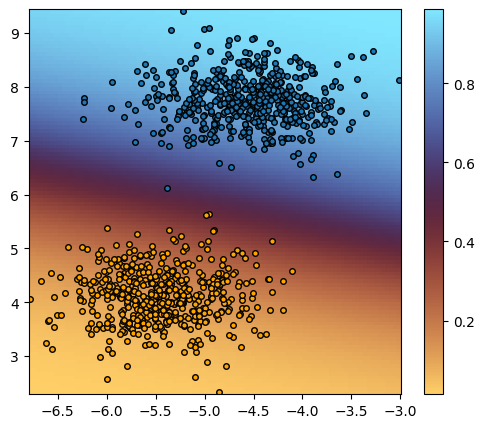

In [67]:
# initialize range of input values

min_x = np.min(df[['x1', 'x2']].to_numpy(), axis=0)
max_x = np.max(df[['x1', 'x2']].to_numpy(), axis=0)

K = 100
x1s = np.linspace(min_x[0], max_x[0], K)
x2s = np.linspace(min_x[1], max_x[1], K)
x1s, x2s = np.meshgrid(x1s, x2s)

# zip the inputs up into a (K*K, 2) array
Xstar = np.vstack((x1s.flatten(), x2s.flatten())).T

df_star = pd.DataFrame(data=Xstar, columns=['x1','x2'])

yhat = model.predict(df_star).reshape((K,K))

f, ax = plt.subplots(1, 1, figsize=(6, 5))

cp = ax.pcolor(x1s, x2s, yhat, cmap=plt.get_cmap('managua')) # 0: orange, 1: blue
f.colorbar(cp)

#
# plot the actual points
#
X = df[['x1','x2']].to_numpy()

y = df['y'].to_numpy()
class0_ix = y == 1 # y = 1, blue
class1_ix = y == 0 # y = 0, orange

ax.plot(X[class0_ix, 0], X[class0_ix, 1], marker='o', markersize=4, linestyle='', markeredgecolor='black', markeredgewidth=1)
ax.plot(X[class1_ix, 0], X[class1_ix, 1], color='orange', marker='o', markersize=4, linestyle='', markeredgecolor='black', markeredgewidth=1)
